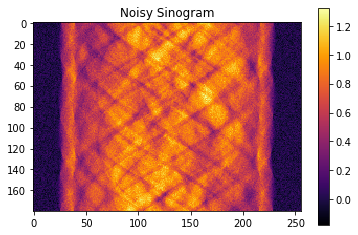

In [1]:
import numpy as np 
import numpy                          
import matplotlib.pyplot as plt

from ccpi.optimisation.algorithms import PDHG, SPDHG

from ccpi.optimisation.operators import BlockOperator, Identity, Gradient
from ccpi.optimisation.functions import ZeroFunction, L1Norm, \
                      MixedL21Norm, BlockFunction, L2NormSquared,\
                          KullbackLeibler, IndicatorBox, TotalVariation
from ccpi.framework import TestData, ImageGeometry, AcquisitionGeometry, BlockDataContainer, AcquisitionData
import os
import sys
from ccpi.plugins.regularisers import FGP_TV 
from ccpi.filters import regularisers
from ccpi.astra.operators import AstraProjectorSimple

import tomophantom
from tomophantom import TomoP2D
import functools

from ccpi.utilities.display import show

data_from_= "tomophantom"

if data_from_ == "cil":
    
    loader = TestData(data_dir=os.path.join(sys.prefix, 'share','ccpi'))
    data = loader.load(TestData.SIMPLE_PHANTOM_2D, size=(128,128))
    ig = data.geometry
    ig.voxel_size_x = 0.01
    ig.voxel_size_y = 0.01  
    
else:
    model = 12 # select a model number from the library
    N = 256 # set dimension of the phantom
    path = os.path.dirname(tomophantom.__file__)
    path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

    phantom_2D = TomoP2D.Model(model, N, path_library2D)    
    ig = ImageGeometry(voxel_num_x = N, voxel_num_y = N, 
                       voxel_size_x = 0.01,
                       voxel_size_y = 0.01)
    data = ig.allocate()
    data.fill(phantom_2D) 
    
# Create acquisition data and geometry
detectors = data.shape[0]
angles = np.linspace(0, np.pi, 180)
ag = AcquisitionGeometry('parallel','2D',angles, detectors, pixel_size_h = 0.01)

np.random.seed(10)
Aop = AstraProjectorSimple(ig, ag, 'gpu')
sin = Aop.direct(data)
noisy_data = 0.*sin
noisy_data.fill(np.random.normal(0, 0.05, size = ag.shape) + sin.as_array())

plt.figure()
plt.imshow(noisy_data.as_array(), cmap = 'inferno')
plt.title('Noisy Sinogram')
plt.colorbar()
plt.show()
    
alpha = 0.1

In [2]:
# Explicit PDHG
f1 = 0.5 * L2NormSquared(b=noisy_data)
f2 = alpha * MixedL21Norm()
F = BlockFunction(f1, f2)
K = BlockOperator(Aop, Gradient(ig))
G = IndicatorBox(lower=0)
normK = K.norm()

sigma = 1./normK
tau = 1./normK

pdhg_explicit_tv = PDHG(f=F, g=G, operator=K, sigma=sigma, tau=tau,
            max_iteration = 1000,
            update_objective_interval=200)    
pdhg_explicit_tv.run(very_verbose=True)

Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    1.03658e+04  -0.00000e+00    1.03658e+04
      200       1000         0.010    2.50881e+02   2.47445e+02    3.43598e+00
      400       1000         0.009    2.50478e+02   2.49933e+02    5.44744e-01
      600       1000         0.009    2.50417e+02   2.50254e+02    1.63091e-01
      800       1000         0.008    2.50390e+02   2.50323e+02    6.69992e-02
----------------------------------------------------------------------------
     1000       1000         0.008    2.50375e+02   2.50378e+02   -2.61549e-03
Stop criterion has been reached.


In [3]:
subsets = 10
size_of_subsets = int(len(angles)/subsets)

# create list of angles
sample = "stride"
if sample =="uniform":
    list_angles = [angles[i:i+size_of_subsets] for i in range(0, len(angles), size_of_subsets)]
elif sample =="stride":  
    list_angles = [angles[i::subsets] for i in range(subsets)]

# create list of geoms
list_geoms = [AcquisitionGeometry('parallel','2D',list_angles[i], detectors, pixel_size_h = 0.01) 
              for i in range(len(list_angles))]   

# create list of data
if sample=="uniform":
    g = BlockDataContainer(*[AcquisitionData(noisy_data.as_array()[i:i+size_of_subsets,:]) for i in range(0, len(angles), size_of_subsets)])
elif sample =="stride":  
    g = BlockDataContainer(*[AcquisitionData(noisy_data.as_array()[i::subsets,:]) for i in range(subsets)])
    
# create Blockoperator
tmp_A = [AstraProjectorSimple(ig, list_geoms[i], device = "gpu") for i in range(subsets)]
A = BlockOperator(*tmp_A + [Gradient(ig)])

# create block function
tmp_F = [0.5*L2NormSquared(b = g[i]) for i in range(subsets)]
F = BlockFunction(*tmp_F,  alpha * MixedL21Norm())

# Positivity constraint of G
G = IndicatorBox(lower=0)

# list of probs
prob = [1/(2*subsets)]*(len(A)-1) + [1/2]
print("Sum of prob {} ".format(sum(prob)))

# every 20 (explicit half time gets to the gradient)

spdhg_explicit_tv = SPDHG(f = F, g = G, operator = A, 
              max_iteration = 1000,
              update_objective_interval = 200, prob = prob)
spdhg_explicit_tv.run(20*50, very_verbose = True)    

Initialised GradientOperator with C backend running with  20  threads
Sum of prob 1.0 
SPDHG setting up
Computing norms
Finished Computing norms
Update objective
Finished Update objective
SPDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    1.03658e+04  -0.00000e+00    1.03658e+04
      200       1000         0.004    2.59794e+02   1.80746e+02    7.90473e+01
      400       1000         0.003    2.52154e+02   2.33677e+02    1.84776e+01
      600       1000         0.004    2.50900e+02   2.44565e+02    6.33503e+00
      800       1000         0.004    2.50577e+02   2.48131e+02    2.44608e+00
----------------------------------------------------------------------------
     1000       1000         0.004    2.50466e+02   2.49201e+02    1.26469e+00
Stop criterion has been reached.


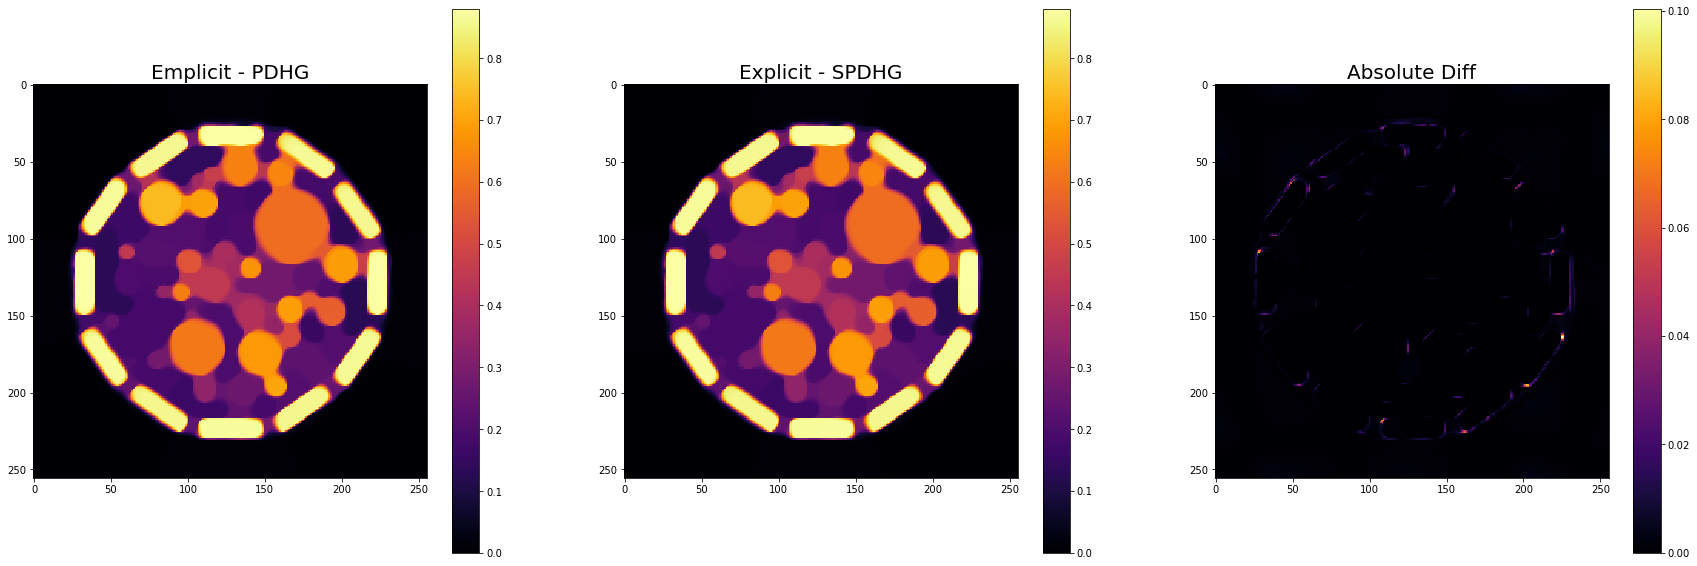

In [4]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.imshow(pdhg_explicit_tv.get_output().as_array(), cmap = 'inferno')
plt.title('Emplicit - PDHG', fontsize=20)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(spdhg_explicit_tv.get_output().as_array(), cmap = 'inferno')
plt.title('Explicit - SPDHG', fontsize=20)
plt.colorbar()


plt.subplot(1,3,3)
plt.imshow((pdhg_explicit_tv.get_output()-spdhg_explicit_tv.get_output()).abs().as_array(), cmap = 'inferno')
plt.title('Absolute Diff', fontsize=20)
plt.colorbar()
